# Assignment 7: Linear Model Selection and Regularization

Dataset(s) needed:
Kaggle House Prices (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

Libraries needed:
glmnet

Convert building class code (MSSubClass) to a factor.
For numeric NA values, impute by taking each column’s mean.
For non-numeric, apply an appropriate technique.



In [1]:
library("caret")
library("glmnet")
# library("elasticnet")
house <- read.csv("https://library.startlearninglabs.uw.edu/ML210/train.csv")
# cat("\n---------- FULL DATASET -----------\n")
# str(house)
# head(house)

house$MSSubClass  <- as.factor(house$MSSubClass)

###### Show # of NA's:
# sapply(house, function(x) sum(is.na(x)))

##### function to summarize features with NA's (for my own sanity check!!!) #####
summarizeNA <- function(df)
    {
        df <- df[sapply(df, function(x) sum(is.na(x)) > 0)] # show ONLY features with NA's
        
        result <- data.frame(na.count = sapply(df, function(x) length(x[is.na(x)])),
                    na.freq = sapply(df, function(x) length(x[is.na(x)])/length(x)),
                    feature.class = sapply(df, function(x) ifelse(is.factor(x), "factor", "num")))
                        
        result$subcategories <- sapply(X = rownames(result), function(x) unique(house[, colnames(house) == x]))
        return(result)
    }

na.df <- summarizeNA(house)                                       
                                           
##### remove features with >50% missing values (per Tomasz' recommendation)
excludedFeatures <- rownames(na.df)[na.df$na.freq > 0.5]
house <- house[, !(colnames(house) %in% excludedFeatures)]
# cat("\n---------- REMOVED: 4 FEATURES WITH >50% MISSING -----------\n")                                       
# summarizeNA(house)   
# str(house)   

##### imputing NA values for numeric features using column mean                                       
house$LotFrontage <- ifelse(is.na(house$LotFrontage), mean(house$LotFrontage, na.rm = TRUE), house$LotFrontage)                                       
house$MasVnrArea <- ifelse(is.na(house$MasVnrArea), mean(house$MasVnrArea, na.rm = TRUE), house$MasVnrArea) 
house$GarageYrBlt <- ifelse(is.na(house$GarageYrBlt), mean(house$GarageYrBlt, na.rm = TRUE), house$GarageYrBlt)
# cat("\n---------- IMPUTATION: NUMERICAL -----------\n")                                       
# summarizeNA(house)   
# str(house) 

##### imputing NA values for categorical features using most frequent subcategorical (i.e. mode) 
isfactor <- sapply(house, function(x) is.factor(x))
house[,isfactor] <- lapply(house[,isfactor],
                          function(x) factor(ifelse(is.na(x), max(plyr::count(x)$freq, na.rm = TRUE), x)))
# cat("\n---------- IMPUTATION: CATEGORICAL -----------\n")
# summarizeNA(house)
# cat("\n---------- FINAL DATASET FOR DOWNSTREAM ANALYSIS -----------\n")                              
# str(house)

Loading required package: lattice
Loading required package: ggplot2
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-13



Partition the data into training and test sets.

In [2]:
##### split into 80/20 train/test
set.seed(747)
idx <- sample(x = 2, size = nrow(house), replace = TRUE, prob = c(0.8,0.2))
house.train <- house[idx == 1,]
house.test <- house[idx == 2,]

##### one-hot encode all categorical variables using model.matrix
x.train <- model.matrix(object = SalePrice~., data = house.train)[,-c(1,2)] #exclude id and intercept columns
y.train <- house.train$SalePrice

x.test <- model.matrix(object = SalePrice~., data = house.test)[,-c(1,2)] #exclude id and intercept columns
y.test <- house.test$SalePrice

## Lasso Regression

[1] 1000

[1] 12589.25

[1] "Neighborhood16" "OverallQual"    "ExterQual4"     "BsmtFinSF1"    
[5] "TotalBsmtSF"    "X1stFlrSF"      "GrLivArea"      "GarageCars"    
[9] "GarageArea"

[1] 1854266540

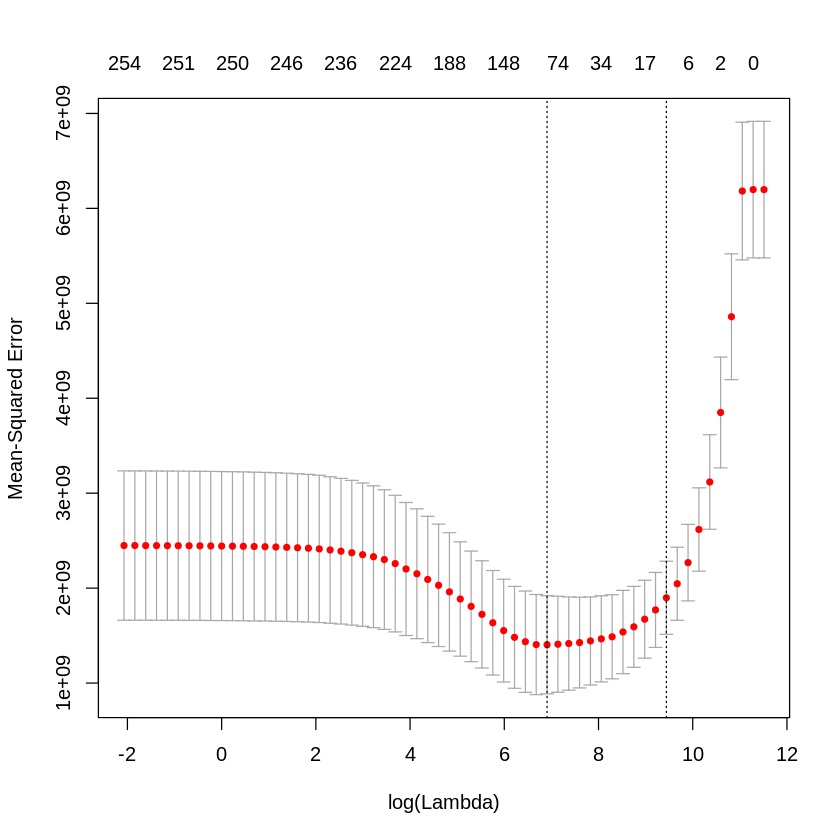

In [3]:
##### find optimal lambda
lambda <- 10^(-10:50/10)
set.seed(79)
lasso.mod.cv <- cv.glmnet(x.train, y.train, alpha=1, lambda=lambda)
plot(lasso.mod.cv)

lasso.lambda.min <- lasso.mod.cv$lambda.min 
lasso.lambda.1se <- lasso.mod.cv$lambda.1se 

lasso.lambda.min
lasso.lambda.1se

##### fit lasso regression using lambda.1se
lasso.mod <- glmnet(x.train, y.train, alpha = 1, lambda = lasso.lambda.1se)
names(which(abs(coef(lasso.mod)[,1]) > 0))[-1] # number of features chosen

##### test MSE
lasso.pred <- predict(object = lasso.mod, s = lasso.lambda.1se, newx = x.test)

lasso.test.MSE <- mean((lasso.pred - y.test)^2)
lasso.test.MSE

How many columns has the model chosen?

> ANSWER: The "optimal" number of features occurs at ___lasso.lambda.1se___ (1 SD away from ___lasso.lambda.min___). For this particular model, the number of chosen features is about 10.

Using t value, what are the most important variables according to your model?
To what extent does this match your intuition?

In [4]:
##### for lasso, important variables are those whose magnitude is greater than 0 and lambda = lambda.1se
names(which(abs(coef(lasso.mod)[,1]) > 0))[-1]

[1] "Neighborhood16" "OverallQual"    "ExterQual4"     "BsmtFinSF1"    
[5] "TotalBsmtSF"    "X1stFlrSF"      "GrLivArea"      "GarageCars"    
[9] "GarageArea"

> ANSWER: I am not sure what a "t value" refers to for lasso regression. But, lasso shrinks all "unimportant" features to zero. Therefore, the "important" variables are those with non-zero coefficents. According to this model, these features are ___'Neighborhood16' 'OverallQual' 'ExterQual4' 'BsmtFinSF1' 'TotalBsmtSF' 'X1stFlrSF' 'GrLivArea' 'GarageCars' 'GarageArea'___. Some of these features (neighborhood, overall quality, external quality, garage size) make sense that they would have a large effect on home price, since they measure the quality of the house. Other features (basement area), not so much!

## Ridge Regression

Perform ridge regression, while choosing optimum value of hyperparameter λ.

[1] 31622.78

[1] 199526.2

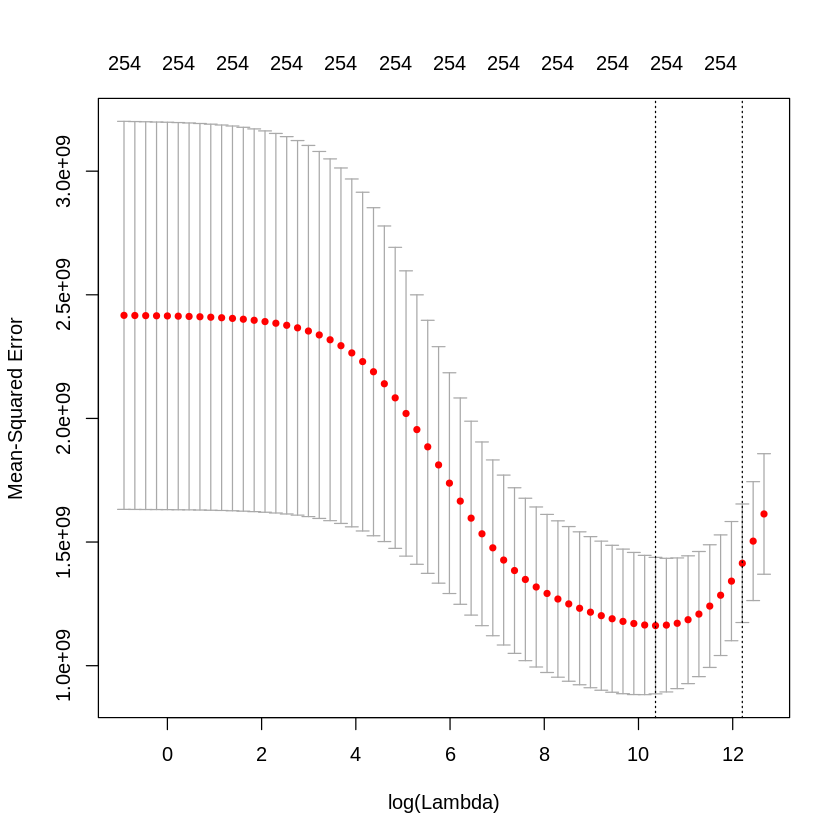

In [5]:
##### finding optimal lambda
set.seed(791)
lambda <- 10^(-5:55/10)
ridge.mod.cv <- cv.glmnet(x=x.train, y=y.train, alpha = 0, lambda=lambda)
plot(ridge.mod.cv)

ridge.lambda.min <- ridge.mod.cv$lambda.min
ridge.lambda.1se <- ridge.mod.cv$lambda.1se

ridge.lambda.min
ridge.lambda.1se

##### fit ridge regression using lambda.1se
ridge.mod <- glmnet(x=x.train, y=y.train, alpha = 0, lambda = ridge.lambda.1se)

What is your mean squared error (MSE)?

In [6]:
##### predict SalePrice using ridge.mod model and ridge.lambda.1se
ridge.pred <- predict(object = ridge.mod, s = ridge.lambda.1se, newx = x.test)

##### calculate test MSE
ridge.test.MSE <- mean((ridge.pred - y.test)^2)
ridge.test.MSE

[1] 1346239710

> ANSWER: test MSE for this particular model is 1346239709.78

## Elastic Net Regression

Perform elastic net regression. Use the caret library's feature for selecting the best value of α.


In [8]:
##### using caret to select best alpha
grid <- grid<-expand.grid(alpha=seq(0,1,by=0.1), 
                          lambda = seq(-10^5, 10^5, by = 100))

enr.train <- caret::train(SalePrice~., house.train[,-1],
                          method = "glmnet",
                          trControl = trainControl(method = "cv"),
                          tuneGrid = grid)

# enr.train ==> best alpha/lambda from train() function: alpha = 0.1 and lambda = 8700

##### fit elastic regression and calculate test MSE
en.mod <- glmnet(x=x.train, y=y.train, alpha = 0.1, lambda = 8700)
en.pred <- predict(object = en.mod, s = 8700, newx = x.test)
en.test.MSE <- mean((en.pred - y.test)^2)

# compare test MSE for Lasso, ridge, and elastic net
lasso.test.MSE
ridge.test.MSE
en.test.MSE

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

[1] 1854266540

[1] 1346239710

[1] 811543862

> ANSWER: the caret::train() function has chosen an optimum $\alpha=0.1$ and optimal $\lambda=8700$. The elastic net model gives a test MSE of 811543862, 56% improvement over lasso and 40% improvement of ridge! For this particular data set, it appears the elastic net method outperforms both the lasso and ridge.